<img align="right" width="200" height="200" src="https://static.wikia.nocookie.net/lego/images/2/23/PPG_logo.png"> 

# <span style="color:#EF7C8E">Introduction - Heuristic Modeling Assignment - Machine Learning </span>
 


## <span style="color:#55BB99"> By: Wejdan Al-Ahmadi</span>
<hr style="border:2px solid gray"> </hr>

## <span style="color:#726060">Objectives:</span>

* Continue to work on the heuristic we started in the lecture and see if you can improve the model's accuracy.
* Add at least two additional conditions to the heuristic model and see if they improve accuracy.
* Report your highest accuracy at the end of your notebook and turn it into the Learn Platform.

In [1]:
#here is an example of how to build and populate a hurestic model

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import time
import datetime
from matplotlib.pyplot import figure

# Load Data
df = pd.read_csv('./data/seattle_weather_1948-2017.csv')

### <span style="color:#EF7C8E">1. Data Cleaning</span>

In [2]:
def RAIN_INSERTION(cols):
    """
    Insert False where NaN values are present
    """
    RAIN=cols[0]
    if pd.isnull(RAIN):
        return False
    else:
        return RAIN
    
def PRCP_INSERTION(col):
    """
    Insert the Mean of PRCP where NaN values are present
    """
    PRCP=col[0]
    if pd.isnull(PRCP):
        return df['PRCP'].mean()
    else:
        return PRCP

In [3]:
# Apply the functions
df['RAIN']=df[['RAIN']].apply(RAIN_INSERTION,axis=1)
df['PRCP']=df[['PRCP']].apply(PRCP_INSERTION,axis=1)

In [4]:
# First quartile (Q1)
Q1 = np.percentile(df['TMAX'], 25, interpolation = 'midpoint')
  
# Third quartile (Q3)
Q3 = np.percentile(df['TMAX'], 75, interpolation = 'midpoint')
  
# Interquaritle range (IQR)
IQR = Q3 - Q1

# lower bound outliers --> Q1 - 1.5(IQR)
# higher bound outliers --> Q3 + 1.5 (IQR)


print(Q3+ 1.5*(IQR))

97.5


In [5]:
df.head(5)

DATE  PRCP  TMAX  TMIN  RAIN
0  1948-01-01  0.47    51    42  True
1  1948-01-02  0.59    45    36  True
2  1948-01-03  0.42    45    35  True
3  1948-01-04  0.31    45    34  True
4  1948-01-05  0.17    45    32  True

In [6]:
#Dropping the outliers from TMIN column
df=df.drop(df[df['TMIN']<17 ].index)
#Dropping the outliers from TMAX columns i.e. the value more than 100
df=df.drop(df[(df['TMAX']>97.5) | (df['TMAX']< 21.5)].index)
#Dropping the outliers from PRCP columns i.e. the value more than 0.275
df=df.drop(df[(df['PRCP']>0.25) | (df['PRCP']< -0.15) ].index)

### <span style="color:#EF7C8E">2. Coding Heuristic by hand and evaluating</span>

Conditions: 
- If it rained yesterday or the day before then it will rain today

In [7]:
# Reset index and drop index column
df = df.reset_index().drop("index", axis=1)

<AxesSubplot:xlabel='TMIN', ylabel='Count'>

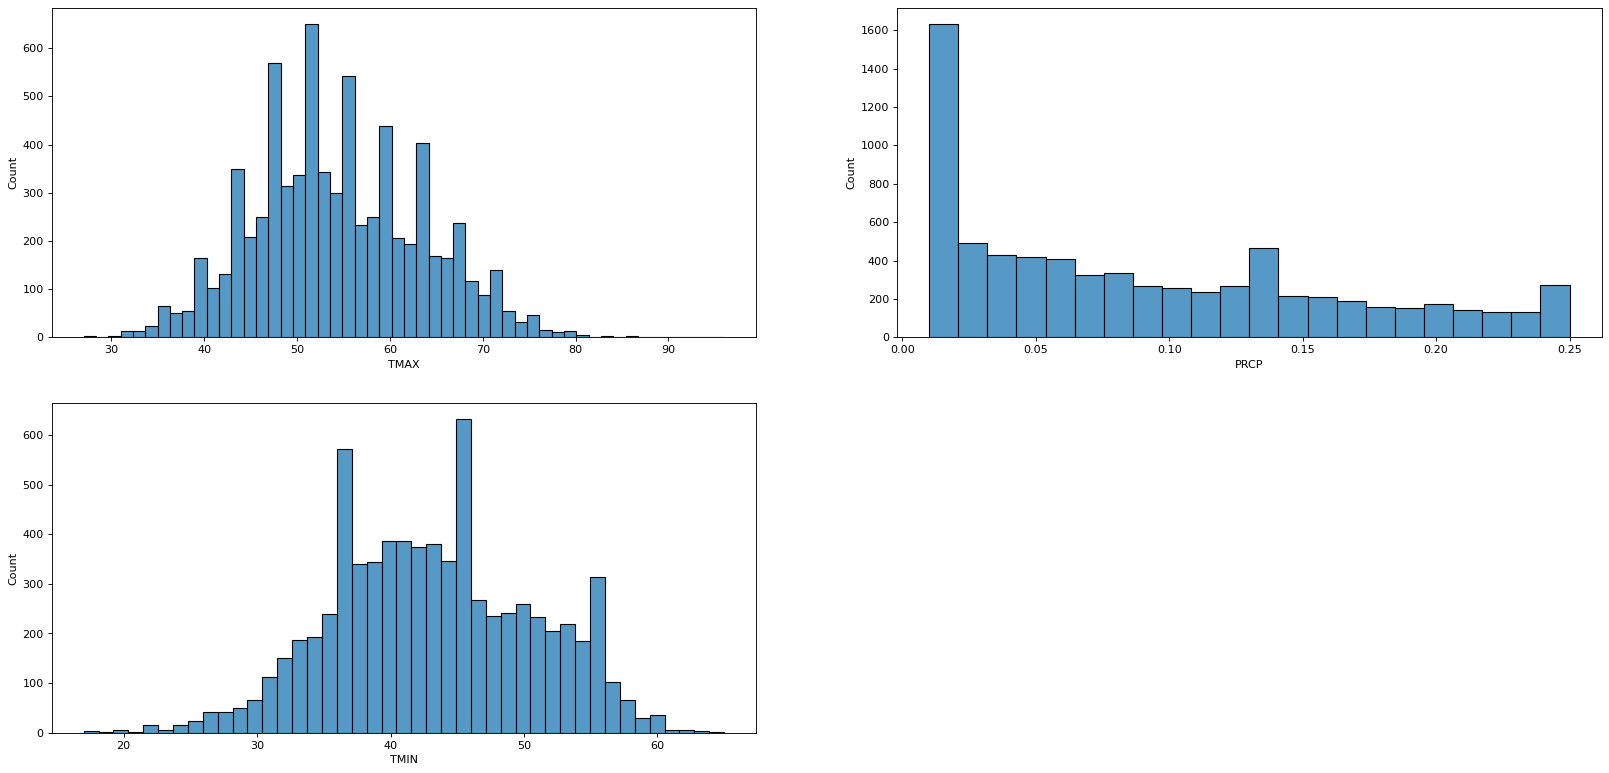

In [8]:
# Plotting the TMAX, TMIN and PRCP when it rains to get the numbers to use in my conditions
figure(figsize=(25, 12), dpi=80)
plt.subplot(2,2,1)
sns.histplot(x="TMAX", data=df[df["RAIN"]==True])
plt.subplot(2,2,2)
sns.histplot(x="PRCP", data=df[df["RAIN"]==True])
plt.subplot(2,2,3)
sns.histplot(x="TMIN", data=df[df["RAIN"]==True])


In [9]:
# Create function to perform our heuristic

# rain --> rain
# rain, 'unknown' --> rain 

# x --> Tomorrow
# x-1 --> Today
# x-2 --> Yesterday

def heuristic(df):
    
    """
    Simple heuristic:
    
    If it rained yesterday or the day before yesterday
    
    then predict rain else predict no rain
    
    Frist two rows are predicted false be default
    """
    
    preds = []
    for x in range(len(df)):
        if x <2:
            preds.append(False)
        else:
            if (df.iloc[x-1]["RAIN"] == True):
                if(df.iloc[x]["TMAX"]<=65) & (df.iloc[x]["PRCP"] >=0.01)&(df.iloc[x]["TMIN"]<=45):
                    preds.append(True)
                else: 
                    preds.append(False)  
            elif (df.iloc[x-2]["RAIN"] == True):
                if (df.iloc[x]["TMAX"]<=65) & (df.iloc[x]["PRCP"] >=0.01)&(df.iloc[x]["TMIN"]<=45):
                    preds.append(True)
                else:
                    preds.append(False)
            elif (df.iloc[x-3]["RAIN"] == True):
                if (df.iloc[x]["TMAX"]<=65) & (df.iloc[x]["PRCP"] >=0.01)&(df.iloc[x]["TMIN"]<=45):
                    preds.append(True)
                else:
                    preds.append(False)

            else: 
                preds.append(False)
    return preds

# this ones accuracy is: 0.7650390535787694

In [11]:
# Apply Heuristic
df["preds"] = heuristic(df)


# Extract results and create columns for each
w,x,y,z = calc_confuse(df)

df["FP"] = w
df["TP"] = x
df["FN"] = y
df["TN"] = z

# Calculate Accuracy
(sum(df["TP"]) + sum(df["TN"])) / len(df)

0.8408623761019504

### <span style="color:#EF7C8E">3. Calculating the confusion matrix</span>

In [10]:
# Determine Accuracy

# Create function to to find values

def calc_confuse(df):
    
    "Calculate all possible results of a confusion matrix"

    # Hold all possible values and set to zero
    FP = np.zeros(len(df))
    TP = np.zeros(len(df))
    FN = np.zeros(len(df))
    TN = np.zeros(len(df))
    
    for x in range(len(df)):
        
        # True Positive
        if (df["RAIN"].iloc[x] == True) & (df["preds"].iloc[x] == True):
            TP[x] = 1
        # True Negative
        elif (df["RAIN"].iloc[x] == False) & (df["preds"].iloc[x] == False):
            TN[x] = 1
        # False Negative
        elif (df["RAIN"].iloc[x] == True) & (df["preds"].iloc[x] == False):
            FN[x] = 1
        # False Positive
        else:
            FP[x] = 1
    
    return FP, TP, FN, TN

In [12]:
# Extract results and create columns for each
w,x,y,z = calc_confuse(df)

df["FP"] = w
df["TP"] = x
df["FN"] = y
df["TN"] = z

In [13]:
# Calculate Accuracy
(sum(df["TP"]) + sum(df["TN"])) / len(df)

0.8408623761019504

In [14]:
# Baseline Model Prediction
# What would be our accuracy if we predicted the majority class

df["RAIN"].value_counts(normalize=True)

False    0.665464
True     0.334536
Name: RAIN, dtype: float64

### <span style="color:#EF7C8E">3. Conclusion:</span>
After taking a deeper look into the dataset, I noticed when the TMAX is higher but not too high it tends to rain, I also noticed that when the PRCP is equal to 0 its almost always not raining, Also when looking into weather forecasting I noticed they tend to look at the day before and the day of. I used this knowledge in writing my code. 
I iterated through the code and tried many different conditions and got a range of accurracies from: {63,64,66,67,69,73,74,76, 84}. 
My Highest accuracy was 84 and I reached it with the following Psuedo code that I implemented into the function: 


Heuristic Psuedo Code: 

 1) If it rained yesterday
 
     1.1) If todays TMAX is 65 degrees or less, AND If todays PRCP is above 0.01, AND If the TMIN is 45 or higher
     
         1.1.1) Then it rained
         
         
    1.2) Else --> It will not rain


 2) Else If it rained two days before
 
     2.1) If todays TMAX is 65 degrees or less, AND If todays PRCP is above 0.01, AND If the TMIN is 45 or higher
     
         2.1.1) Then it rained
  
      2.2) Else --> It will not rain
      
      
 3) Else If it rained three days before
 
     3.1) If todays TMAX is 65 degrees or less, AND If todays PRCP is above 0.01, AND If the TMIN is 45 or higher
     
          3.1.1) Then it rained
            
      3.2) Else --> It will not rain


 4) Else --> It will not rain